In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from tqdm import trange

In [2]:
from pywk.timeseries.timeseries import remove_linear_trend
from pywk.spectrum import get_window_spectra
from pywk.spectrum.significance import get_log_distance_statistic
from pywk.spectrum.significance import bootstrap_mean_difference_test

In [3]:
ds = xr.open_dataset("data/olr.2xdaily.1979-2022.nc")
olr_a = ds.olr.sel(time=slice("1980-01", "1982-12", None), lat=slice(15,-15, None)).sortby("lat")
olr_b = ds.olr.sel(time=slice("2020-01", "2022-12", None), lat=slice(15,-15, None)).sortby("lat")
olr_a = remove_linear_trend(olr_a)
olr_b = remove_linear_trend(olr_b)

In [4]:
spc_quantity = "power"
window_length = "92D"
overlap_length = "60D"
data_frequency = "12h"
component_type = "symmetric"
spectra_a = get_window_spectra("power", olr_a, component_type, data_frequency,
                               window_length, overlap_length)
spectra_b = get_window_spectra("power", olr_b, component_type, data_frequency,
                               window_length, overlap_length)

### Bootstrap 

In [5]:
alpha = 5/100
resamplings = trange(1000)
observed_log_distance = get_log_distance_statistic(spectra_a, spectra_b)
bootstrap_results =  bootstrap_mean_difference_test(spectra_a, spectra_b,
                                                    alpha=alpha,
                                                    resamplings=resamplings)

100%|██████████| 1000/1000 [00:40<00:00, 24.84it/s]


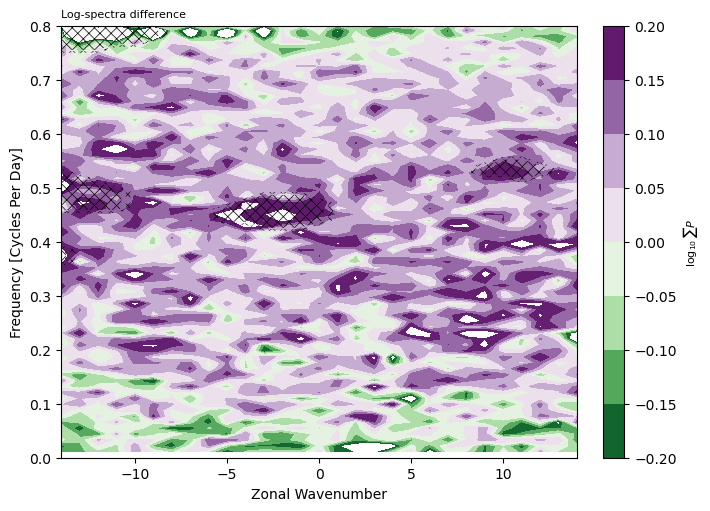

In [6]:
fig, ax = plt.subplots(1 , 1, figsize=(7, 5), constrained_layout=True)
plt.rcParams['hatch.linewidth'] = 0.5

diff = observed_log_distance.values
significant = bootstrap_results.significant.values
k = observed_log_distance.wavenumber
w = observed_log_distance.frequency
levels = np.arange(-0.2, 0.25, 0.05)

cs = ax.contourf(k, w, diff, levels, cmap="PRGn_r")
ax.contourf(k, w, bootstrap_results.significant,
            levels=3,
            hatches=['', '///\\\\\\'],
            cmap="Greys",
            alpha=0.025)
ax.set_xlabel("Zonal Wavenumber")
ax.set_ylabel("Frequency [Cycles Per Day]")
ax.set_title("Log-spectra difference",  fontsize=8, loc='left')
ax.set_xlim(-14, 14)
ax.set_ylim(0, 0.8)
cb = fig.colorbar(cs, ax=ax)
cb.set_label(r"$\log_{10}{\sum P}$", fontsize=8)